In [1]:
import math
from abc import abstractmethod

import numpy as np

from pytools import single_valued

import sumpy.symbolic as sym
from sumpy.expansion import (
        ExpansionBase,
        VolumeTaylorExpansion,
        VolumeTaylorExpansionMixin,
        LinearPDEConformingVolumeTaylorExpansion)
from sumpy.tools import add_to_sac, mi_increment_axis

from sumpy.kernel import LaplaceKernel

In [2]:
class LocalExpansionBase(ExpansionBase):
    """Base class for local expansions.

    .. automethod:: translate_from
    """

    init_arg_names = ("kernel", "order", "use_rscale", "m2l_translation")

    def __init__(self, kernel, order, use_rscale=None,
            m2l_translation=None):
        super().__init__(kernel, order, use_rscale)
        self.m2l_translation = m2l_translation

    def with_kernel(self, kernel):
        return type(self)(kernel, self.order, self.use_rscale,
            self.m2l_translation)

    def update_persistent_hash(self, key_hash, key_builder):
        super().update_persistent_hash(key_hash, key_builder)
        key_builder.rec(key_hash, self.m2l_translation)

    def __eq__(self, other):
        return (
            type(self) is type(other)
            and self.kernel == other.kernel
            and self.order == other.order
            and self.use_rscale == other.use_rscale
            and self.m2l_translation == other.m2l_translation
        )

    @abstractmethod
    def translate_from(self, src_expansion, src_coeff_exprs, src_rscale,
            dvec, tgt_rscale, sac=None, m2l_translation_classes_dependent_data=None):
        """Translate from a multipole or local expansion to a local expansion

        :arg src_expansion: The source expansion to translate from.
        :arg src_coeff_exprs: An iterable of symbolic expressions representing the
                coefficients of the source expansion.
        :arg src_rscale: scaling factor for the source expansion.
        :arg dvec: symbolic expression for the distance between target and
                source centers.
        :arg tgt_rscale: scaling factor for the target expansion.
        :arg sac: An object of type
                :class:`sumpy.assignment_collection.SymbolicAssignmentCollection`
                to collect common subexpressions or None.
        :arg m2l_translation_classes_dependent_data: An iterable of symbolic
                expressions representing the expressions returned by
                :func:`~sumpy.expansion.m2l.M2LTranslationBase.translation_classes_dependent_data`.
        """

In [3]:
class LineTaylorLocalExpansion(LocalExpansionBase):
    def get_storage_index(self, k):
        return k

    def get_coefficient_identifiers(self):
        return list(range(self.order+1))

    def coefficients_from_source(self, kernel, avec, bvec, rscale, sac=None):
        # no point in heeding rscale here--just ignore it
        if bvec is None:
            raise RuntimeError("cannot use line-Taylor expansions in a setting "
                    "where the center-target vector is not known at coefficient "
                    "formation")

        tau = sym.Symbol("tau")

        #compute localtaylor 
        #note that avec goes from our source to expansion center
        #bvec points from our expansion center to a boundary point
        #thus |bvec| = r, the expansion radius
        
        avec_line = avec + tau*bvec

        line_kernel = kernel.get_expression(avec_line)

        from sumpy.symbolic import USE_SYMENGINE

        if USE_SYMENGINE:
            from sumpy.derivative_taker import ExprDerivativeTaker
            deriv_taker = ExprDerivativeTaker(line_kernel, (tau,), sac=sac, rscale=1)

            return [kernel.postprocess_at_source(
                        deriv_taker.diff(i), avec).subs(tau, 0)
                    for i in self.get_coefficient_identifiers()]
        else:
            # Workaround for sympy. The automatic distribution after
            # single-variable diff makes the expressions very large
            # (https://github.com/sympy/sympy/issues/4596), so avoid doing
            # single variable diff.
            #
            # See also https://gitlab.tiker.net/inducer/pytential/merge_requests/12

            return [kernel.postprocess_at_source(
                            line_kernel.diff(tau, i), avec)
                    .subs(tau, 0)
                    for i in self.get_coefficient_identifiers()]

    def evaluate(self, tgt_kernel, coeffs, bvec, rscale, sac=None):
        # no point in heeding rscale here--just ignore it
        return sym.Add(*(
                coeffs[self.get_storage_index(i)] / math.factorial(i)
                for i in self.get_coefficient_identifiers()))

    def translate_from(self, src_expansion, src_coeff_exprs, src_rscale,
            dvec, tgt_rscale, sac=None, m2l_translation_classes_dependent_data=None):
        raise NotImplementedError

In [14]:
#Testing Out LineTaylor
laplaceKernel = LaplaceKernel(2)
orderOfExpansion = 4
lineTaylor = LineTaylorLocalExpansion(laplaceKernel, orderOfExpansion)
lineTaylor.coefficients_from_source(laplaceKernel, np.array([2,2]), np.array([2,0]), 1)

[log(2*sqrt(2)), 1/2, 0, -1/2, 3/2]

In [15]:
#Testing Out FlopCounter
from pymbolic.mapper.flop_counter import FlopCounter
import pymbolic as pmbl

x = pmbl.var("x")
u = (x+1+2)**5
diff = pmbl.differentiate(u, 'x')

#Create Instance of FlopCounter
counter = FlopCounter()

#Count Flops for Evaluating u
counter(u)
#Count Flops for Differentiation
counter(diff)

In [61]:
#Get Expression in Sympy - I don't know how to do the following in pymbolic: compute logs/norms of vectors
#import sympy

#tau_sympy = sympy.symbols("t")
#avec = np.array([2,0])
#bvec = np.array([2,0])
#avec_line = avec_line = avec + tau_sympy*bvec

'''It looks like pymbolic can't deal with logs? Therefore I will move onto 3D'''
#kernel_line_expression = sympy.log((avec_line[0]**2 + avec_line[0]**2)**(0.5))

#converter = pmbl.interop.sympy.SympyToPymbolicMapper()
#kernel_line_expression_pymbolic = converter(kernel_line_expression)
#pmbl.differentiate(kernel_line_expression_pymbolic, 't')

In [82]:
#3D Pymbolic Flop Computation


#The setup is as follows, source is located at (-1, 0)
#Target located at (0,1)
#Expansion disk is of radius expansion_radius away from (0, 1)

#Compute kernel_line_expression in sympy first
import sympy
tau_sympy = sympy.symbols("t")
expansion_radius = 0.5
avec = np.array([2-expansion_radius,0,0])
bvec = np.array([expansion_radius,0,0])
avec_line = avec_line = avec + tau_sympy*bvec
kernel_line_expression = (avec_line[0]**2 + avec_line[1]**2 + avec_line[2]**2)**(-0.5)

#Convert sympy expression into pymbolic
converter = pmbl.interop.sympy.SympyToPymbolicMapper()
kernel_line_expression_pymbolic = converter(kernel_line_expression)

#Define G(0, \vec{a}+\tau\vec{b}) as coeff0
coeff0 = kernel_line_expression_pymbolic

#Compute higher order derivatives with respect to tau
def recursive_derivative(coeff, n):
    if n == 0:
        return coeff
    else:
        return recursive_derivative(pmbl.differentiate(coeff, "t"), n-1)

#flops_at_order is the number of flops to take i derivatives of coeff0 with respect to tau
flops_at_order = []
flops = []

#compute flops for 10 derivatives
N = 10
for i in range(N):
    flops_at_order.append(counter(recursive_derivative(coeff0, i)))
    
flops_at_order_np = np.array(flops_at_order)

#naively assume that the flops for a order n-taylor expansion is proportional to computing the previous
#n-derivatives
#i.e. sum elements up to index i in flops_at_order_np
for i in range(N):
    flops.append(np.sum(flops_at_order_np[:i]))

flops_np = np.array(flops)
order = np.array([i for i in range(N)])

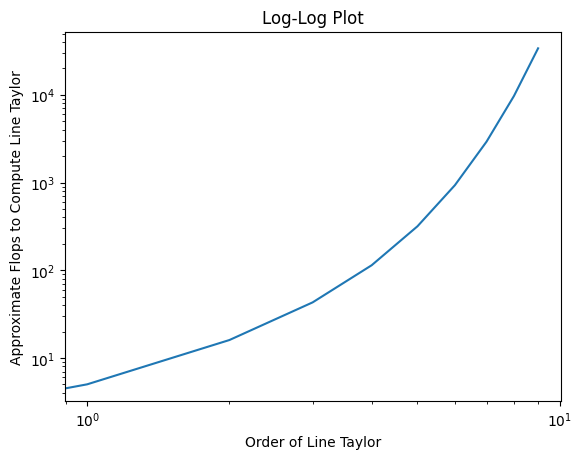

In [94]:
#Plot Order vs Flops To Compute Line Taylor
import matplotlib.pyplot as plt
plt.loglog(order, flops_np)
plt.xlabel("Order of Line Taylor")
plt.ylabel("Approximate Flops to Compute Line Taylor")
plt.title("Log-Log Plot")
plt.show()

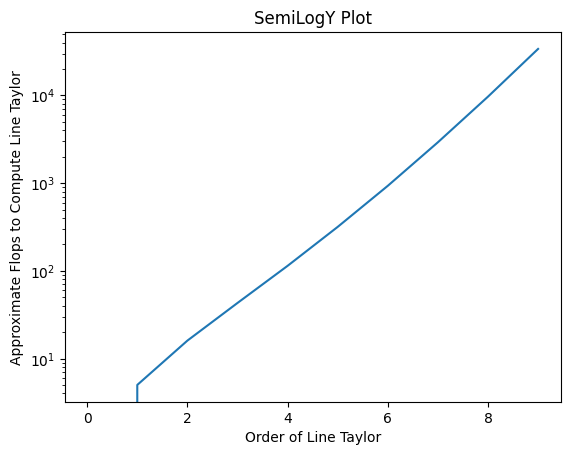

In [95]:
#Sanity Check - Does this Result Make Sense?
#It seems that the complexity is beyond a power law? Perhaps even factorial?
#Factorial makes sense. Is there anyway to check this?
#Semilogyaxis
plt.semilogy(order, flops_np)
plt.xlabel("Order of Line Taylor")
plt.ylabel("Approximate Flops to Compute Line Taylor")
plt.title("SemiLogY Plot")
plt.show()